## Introduction
In order to model complex variable interactions, Neural Networks ingest all features at once, perform mostly black-box calculations and finally return a - hopefully accurate - output. This has obviously proven highly successful but mostly destroys any interpretability right from the start. In 'classic' Statistics, a lot of smart methods had been developed to model non-linear data without compromising for interpretable models. One of these techniques is known as **Generalized Additive Models** (GANs) and can be quite powerful. In today's post, I want to show how to marry Neural Networks with GANs - [not a particularly new invention](https://dl.acm.org/citation.cfm?id=312228) but I still liked the method so I decided to write this anyway. To provide some novelty, the demonstrations are done in [Julia](https://julialang.org/) this time - a language that I believe to be very powerful for many aspects of Data Science, Machine Learning and quantitative programming in general. 

## A quick primer on GAMs
As the name implies, the most important aspect of GAMs is additivity, i.e. we want all its components to sum up to the final prediction. The standard formula for a (regression, the transfer to classification should be obvious) GAM model with $m$ variables is quite self-explanatory:  

$$f_{GAM}(x)=\alpha + f_1(x_1) + \cdots + f_m(x_m).$$

Instead of working with the raw features, we transform each variable through an according, often non-linear, function. The obvious problem here is of course the selection of the right basis functions $f_i$. While Spline basis functions (as e.g. in [MARS regression](https://numbersandcode.com/non-greedy-mars-regression)) has proven to be quite successful, we could basically choose any other transformation as well. If the size of the dataset is large enough, it could therefore make sense to learn the basis functions from the data as well and Neural Networks are a natural choice due to their inherent flexibility and adaptiveness.  

In practice, instead of fitting a single large Neural Network for all features, we fit a smaller Neural Network for each feature according to the formula above. Alluding to the [performance bounds of Residual Neural Networks](https://papers.nips.cc/paper/7332-are-resnets-provably-better-than-linear-predictors.pdf), I decided to also include a linear block in the model, resulting in  
  
$$f_{ResidualGAM}(x)=\alpha + f_1(x_1) + \cdots + f_m(x_m) + X\beta$$  
  
  
where $X$ is the typical design matrix of all features as in the standard Linear Regression case.

## Some thoughts on Julia
At the moment, the main arguments pro Julia in general are definitely its [excellent performance](https://julialang.org/benchmarks/) and the fact that Julia packages are typically written in pure Julia alone. Another point why Julia could become awesome in the future, is the availability and ongoing development of sophisticaed AutoDiff packages like [Zygote.jl](https://github.com/FluxML/Zygote.jl) or [ForwardDiff.jl](https://github.com/JuliaDiff/ForwardDiff.jl). Instead of writing complex pieces of code with Tensorflow's sometimes confusing API, AutoDiff in Julia typically means writing formulas in native Julia code and differentiating straight away. See for example [this video](https://www.youtube.com/watch?v=LjWzgTPFu14) for a nice overview on Zygote's capabilities.  

On the flipside, Julia is evolving rapidly and hence things might often break or not work, even the latest examples from package docs. Also the functional programming paradigm could feel unfamiliar initially if you have only been working with Python so far - R users might actually have a slight edge here. If you are interested in learning the language, there are many sources available at [Julia's official webpage](https://julialang.org/learning/)

## Setup
For this experiment, we'll use the [diamonds dataset](https://www.kaggle.com/shivam2503/diamonds) once again where we want to predict the price of diamond given some characteristic data. In order to perform the necessary data manipulations, I used Julias [Queryverse](https://github.com/queryverse/Queryverse.jl) framework which is inspired by the R tidyverse framework. 

In [1]:
using Flux
using CSV
using DataFrames
using Queryverse
using MLJ
using Random
using LinearAlgebra
using Distributions
using Plots

┌ Info: CUDAdrv.jl failed to initialize, GPU functionality unavailable (set JULIA_CUDA_SILENT or JULIA_CUDA_VERBOSE to silence or expand this message)
└ @ CUDAdrv /Users/saremseitz/.julia/packages/CUDAdrv/3EzC1/src/CUDAdrv.jl:69


In [2]:
df = CSV.File("diamonds.csv") |> DataFrame
# the piping operator |> makes things feel like working with tidyverse

,Column1,carat,cut,color,clarity,depth,table,price,x
,Int64,Float64,String,String,String,Float64,Float64,Int64,Float64
1,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95
2,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89
3,3,0.23,Good,E,VS1,56.9,65.0,327,4.05
4,4,0.29,Premium,I,VS2,62.4,58.0,334,4.2
5,5,0.31,Good,J,SI2,63.3,58.0,335,4.34
6,6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94
7,7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95
8,8,0.26,Very Good,H,SI1,61.9,55.0,337,4.07
9,9,0.22,Fair,E,VS2,65.1,61.0,337,3.87


## Data manipulation
This part is quite simple - we only need to onehot-encode categorical data in order to make the algorithms work later on.

In [3]:
X_num = convert(Matrix{Float32}, df |> @select(:carat, :depth, :table, :x, :y, :z)|> DataFrame)

X_cut_dummy = Flux.onehotbatch(Array(df[:,3]), unique(Array(df[:,3]))) |> transpose
X_color_dummy = Flux.onehotbatch(Array(df[:,4]), unique(Array(df[:,4]))) |> transpose
X_clarity_dummy = Flux.onehotbatch(Array(df[:,5]), unique(Array(df[:,5]))) |> transpose

X = hcat(X_num, X_cut_dummy, X_color_dummy, X_clarity_dummy)

y = df.price

53940-element Array{Int64,1}:
  326
  326
  327
  334
  335
  336
  336
  337
  337
  338
  339
  340
  342
    ⋮
 2756
 2756
 2756
 2756
 2757
 2757
 2757
 2757
 2757
 2757
 2757
 2757

## Building a GANN with Julia, Flux and Zygote
When I first learned about Flux and Zyogte, I was impressed by how easy they make it to build customized Neural Network architectures and differentiable structures in general. For example, my (currently Github only) [experiments with Memory Augemented Neural Networks](https://github.com/SaremS/MANN) are written with Flux and Zygote's predecessor Tracker. As you can see below, we can build the whole architecture in about 25-30 lines of Julia code (excluding line-breaks, comments and additional functions). I also added some explanatory comments in case you are unfamiliar with Julia.

In [4]:
struct GANN #Julia is a non-OOP language like C for example - hence, there are no classes
    nets
    W
    b
end
Flux.@treelike(GANN) #This tells Flux to look for parameters in the GANN struct

function GANN(n_features::Int, n_hidden::Int) 
    #we can simply use an array of Neural Networks ("Chains" in the Flux framwork) for the per-feature networks
    nets = [Chain(Dense(1, n_hidden, relu), Dense(n_hidden, 1)) for i in 1:n_features] 
    W = Float32.((randn(n_features, 1)))
    b = Float32.((randn(1)))
    
    GANN(nets, W, b)
end

#We split the per-feature network predictions and the linear predictions into two parts - this makes it
#more convenient to infer the outputs later on
function net_output(gann::GANN, X::Array)
    n_variables = size(gann.nets)[1]
    n_rows = size(X)[1]
    net_output = [reshape(gann.nets[1](reshape(X[:,i], (1,n_rows))), (n_rows,1))
                    for i in 1:n_variables]
    
    hcat(net_output...)
end


function linear_output(gann::GANN, X::Array)
    X*gann.W .+ gann.b
end

#finally, we create a function that combines per-feature network and linear outputs
function (m::GANN)(X::Array)
    linear_output(m, X) .+ sum(net_output(m, X), dims = 2)
end

#If any functions change, we need to tell Zygote to update internally as well 
Flux.Zygote.refresh()

## Preparing the data for training
Here, we perform a typical train-test split and re-scale the data.

In [43]:
train_idx, test_idx = partition(eachindex(y), 0.75, shuffle = false)

X_train, X_test = X[train_idx,:], X[test_idx,:]
y_train, y_test = (Float32.(y[train_idx])), (Float32.(y[test_idx]))


X_train_m = X_train
X_test_m = X_test


mxs = [] # containers to store means and standard deviations of all exogenous features
sxs = []
for i in 1:11
    mx = mean(X_train_m[:,i])
    sx = std(X_train_m[:,i])
   
    X_train_m[:,i] .-= mx
    X_test_m[:,i] .-= mx
   
    X_train_m[:,i] ./= sx
    X_test_m[:,i] ./= sx

    push!(mxs, mx)
    push!(sxs, sx)
       
end

my = mean(y_train[:,1])
sy = std(y_train[:,1])

y_train .-= my
y_train ./= sy

40455-element Array{Float32,1}:
 -0.99589497
 -0.99589497
 -0.9956654 
 -0.994058  
 -0.9938284 
 -0.9935988 
 -0.9935988 
 -0.99336916
 -0.99336916
 -0.99313956
 -0.9929099 
 -0.9926803 
 -0.99222106
  ⋮         
 -0.8094439 
 -0.8094439 
 -0.8094439 
 -0.8092143 
 -0.8092143 
 -0.8092143 
 -0.8089847 
 -0.8089847 
 -0.8089847 
 -0.8089847 
 -0.8089847 
 -0.8089847 

## Preparing model and optimizer
This is quite standard. Since the training set is static, the loss function is also fixed on the training set.

In [6]:
Random.seed!(345)
gann = GANN(26, 10)

mse_loss(x) = mean((gann(x) .- reshape(y_train, (40455, 1))).^2)
#there are also built-in error functions in Flux

Flux.Zygote.refresh()

opt = Flux.ADAM(1e-1)

ADAM(0.1, (0.9, 0.999), IdDict{Any,Any}())

## Running the optimization
Also nothing too special here. Gradient calculation and parameter optimization are separated - this is rather personal preference than necessity.

In [7]:
ps = Flux.params(gann)

for i in 1:400
    loss, back = Flux.Zygote.pullback(()->mse_loss(X_train_m),ps)
    grads = back(1.)
    
    if i%40==0; println(loss) end

    Flux.Optimise.update!(opt,ps,grads)
end

0.22934754
0.09029856
0.08533483
0.08283875
0.08104308
0.07975853
0.07886767
0.07822754
0.0777392
0.07735237


## Inspecting the results
Next, we want to see the marginal contribution of each variable like we would do for a plain linear model. Since the model is additive, we can simply cumulate the non-linear and linear effect of the single variables. Also keep in mind that missing important features or feature interactions might lead to unintuitive results. On the other hand, encountering strange effects like locally decreasing price for increasing diamond size could help us debugging the model or raise the need for additional information. 

In [56]:
function rescale(x, μ, σ)
    x .* σ .+ μ
end

function plot_marginal_effect(ft::Int)
    mn = minimum(X_train_m[:,ft])
    mx = maximum(X_train_m[:,ft])

    vals = collect(range(mn, length=1000, mx))[:,:]

    linear_effect = gann.W[ft,1] .* vals[:,1]
    nonlinear_effect = transpose(gann.nets[ft](reshape(vals[:,1],(1,1000))))

    plot(rescale(vals[:,1], mxs[ft], sxs[ft]), rescale(linear_effect .+ nonlinear_effect, my, sy), lw=3,
            label = "Marginal Effect")
    xlabel!("Variable Value")
    ylabel!("Marginal Effect on Price")
end

plot_marginal_effect (generic function with 1 method)

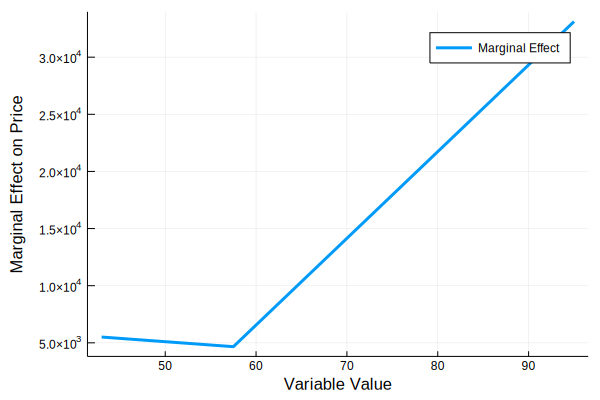

In [57]:
plot_marginal_effect(3)

Finally, let's have a look at the RMSE that our model produces on the test-set:

In [10]:
rmse_gann = sqrt(mean((rescale(gann(X_test_m), my, sy).-y_test).^2))

791.3081f0

# Performance comparison with a plain linear model 
Adding non-linearities to the model should considerably increase performance in comparison to a linear-only model. Otherwise, it would not make much sense to make the model overly complex and risk a performance decrease on out-of-sample data.

In [47]:
X_tr_b = hcat(X_train_m, ones(size(X_train_m)[1]))
X_te_b = hcat(X_test_m, ones(size(X_test_m)[1]))

β = inv(transpose(X_tr_b)*X_tr_b .+ 1e-4)*transpose(X_tr_b)*y_train

lin_preds = X_te_b * β

13485-element Array{Float64,1}:
 -1.2107783843884141 
 -1.206658075772916  
 -1.2104818326065612 
 -1.213302372442071  
 -1.2026994966480613 
 -0.9165333374160093 
 -0.9937964451259677 
 -1.1370391674264897 
 -1.1475814672895348 
 -1.1370391674264897 
 -1.138697053197423  
 -1.1345762395116963 
 -0.9944770809812434 
  ⋮                  
 -0.40726120268125204
 -0.3552963279933893 
 -0.04069043226788388
 -0.6135738229882306 
  0.10760589467562953
  0.10106178357843076
 -0.6520996125233193 
 -0.5918234533696183 
 -0.6720057970187654 
 -0.703548958046503  
 -1.0207233638955773 
 -1.025045027407605  

As expected, the linear model performs worse than the GANN model. In fact, adding non-linearities almost halved the RMSE.

In [49]:
rmse_linear = sqrt(mean((rescale(lin_preds, my, sy).-y_test).^2))

1484.2417363861507

## Performance comparison with a Residual Neural Network
For completeness sake, let's also compare the results with a Neural Network architecture that uses all input features at once. Here, I decided to use a one-layer ResNet as the topology is closer to the GANN above than a standard Neural Network.

In [17]:
struct ResNet
    net
    W
    b
end
Flux.@treelike(ResNet)


function ResNet(n_features::Int, n_hidden::Int) 
    net = Chain(Dense(n_features, n_hidden, relu), Dense(n_hidden, 1))
    W = Float32.((randn(n_features, 1)))
    b = Float32.((randn(1)))
    
    ResNet(net, W, b)
end


function net_output(resn::ResNet, X::Array)
    n_rows, n_variables = size(X)
    
    rnet.net(transpose(X))[1,:]
end


function linear_output(resn::ResNet, X::Array)
    (X*resn.W .+ resn.b)[:,1]
end


function (m::ResNet)(X::Array)
    net_output(m, X) + linear_output(m, X)
end

Flux.Zygote.refresh()

In [18]:
Random.seed!(345)
rnet = ResNet(26, 10)

ResNet(Chain(Dense(26, 10, relu), Dense(10, 1)), Float32[1.1799979; -0.12719862; … ; -0.13458526; -1.6977073], Float32[0.6811983])

In [19]:
mse_loss_rnet(x) = mean((rnet(x) .- y_train).^2)
Flux.Zygote.refresh()

opt = Flux.ADAM(1e-1)

ps = Flux.params(rnet)

for i in 1:400
    loss, back = Flux.Zygote.pullback(()->mse_loss_rnet(X_train_m),ps)
    grads = back(1.)
    
    if i%40==0; println(loss) end

    Flux.Optimise.update!(opt,ps,grads)
end

0.09988803
0.064022504
0.040490765
0.029970031
0.027306134
0.026876403
0.026769876
0.026694845
0.026632553
0.026578257


Unfortunately, the GANN model is beaten by the ResNet by a large margin again. We could likely reduce this gap by accounting for variable interactions in the GANN model which was completely ignored so far. 

In [20]:
rmse_rnet = sqrt(mean((rescale(rnet(X_test_m), my, sy).-y_test).^2))

416.54053f0

# Conclusion
There is still a lot of room for improvement - a resonable next step could be adding rule-features from Decision Tree models in a [RuleFit](https://numbersandcode.com/rulefit-interpretable-machine-learning) manner which might ideally get us closer to ResNet.  

An important question now is why even bother with fully interpretable models, when methods like [LIME](https://christophm.github.io/interpretable-ml-book/lime.html) could easily give us post-hoc explanations of a black-box ResNet model. However, there are some arguments against this obvious solution:

1. [Post-hoc explanatations can fall victim to adversarial attacks](https://arxiv.org/pdf/1911.02508.pdf)
2. Interpretable models allow us to naturally incorporate and utilize human prior knowledge
3. Linear models allow us to easily perform statistical inference 
4. At the moment, mathematical properties of linear models are much better researched than black-boxes although this might change in the future

Hence, interpretable models models should still be considered as a valid alternative to complex ML solutions. There are still many ideas to explore and future developments on both ends - performant white-boxes and explainable black-boxes - will likely be very exciting over the next few years.  